In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May  3 23:39:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import sys
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image
import cv2

In [4]:
!cp -r /content/drive/Shareddrives/AML_Project/data/train_X ./train_A
!cp -r /content/drive/Shareddrives/AML_Project/data/train_Y ./train_B

In [5]:
!cp -r /content/drive/Shareddrives/AML_Project/data/val_X ./val_A
!cp -r /content/drive/Shareddrives/AML_Project/data/val_Y ./val_B

In [6]:
!cp -r /content/drive/Shareddrives/AML_Project/data/test_X ./test_A
!cp -r /content/drive/Shareddrives/AML_Project/data/test_Y ./test_B

In [7]:
 class CustomDataset(Dataset):
    def __init__(self,pathsA, pathsB):
        self.pathsA = pathsA
        self.pathsB = pathsB   
        self.transforms = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
     
    def __getitem__(self, index):
        imageA = Image.open(self.pathsA[index%len(self.pathsA)])
        imageA = imageA.resize((256,256),Image.LANCZOS)
        t_imageA = self.transforms(imageA)
        
        imageB = Image.open(self.pathsB[index%len(self.pathsB)])
        imageB = imageB.resize((256,256),Image.LANCZOS)
        #print(imageB.size)
        t_imageB = self.transforms(imageB)
        return t_imageA, t_imageB

    def __len__(self):
        
        return max(len(self.pathsA),len(self.pathsB))

In [8]:
path_trainA = glob.glob("./train_A/*.png")
path_trainB = glob.glob("./train_B/*.jpg")
path_testA = glob.glob("./test_A/*.png")
path_testB = glob.glob("./test_B/*.jpg")
path_valA = glob.glob("./val_A/*.png")
path_valB = glob.glob("./val_B/*.jpg")

In [9]:
dataset_train = CustomDataset(path_trainA,path_trainB)
dataset_test = CustomDataset(path_testA,path_testB)
dataset_val = CustomDataset(path_valA,path_valB)

print(len(dataset_train))
print(len(dataset_test))
print(len(dataset_val))

loader_test = DataLoader(dataset_test,batch_size=1,shuffle=False)
loader_train = DataLoader(dataset_train,batch_size=1,shuffle=False)
loader_val = DataLoader(dataset_val,batch_size=1,shuffle=False)

1000
500
500


torch.Size([256, 256, 3])


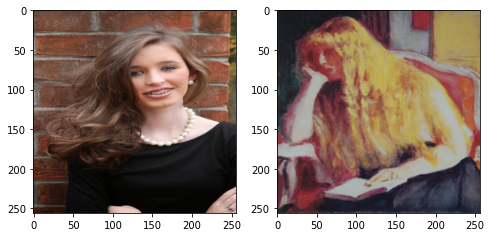

In [10]:
it = iter(loader_val)
trash = next(it)
trash = next(it)
test = next(it)
testA = test[0]#.to(device)
testB = test[1]#.to(device)
h_z = [testA,testB]
print(test[0][0].permute(1,2,0).size())
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows+1):
    img = h_z[i-1][0].permute(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.imshow((img+1.)/2.)
plt.show()

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        
        self.model = nn.Sequential(
        
                    nn.Conv2d(3, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(512, 1, 4, padding=1) )

        

        
    def forward(self, x):
    
        x =  self.model(x)
        x = F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        return x

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels) )

    def forward(self, x):
        return x + self.residual_block(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                       nn.ReflectionPad2d(3),
                       nn.Conv2d(3, 64, 7),
                       nn.InstanceNorm2d(64),
                       nn.ReLU(inplace=True),

                       nn.Conv2d(64, 128, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(128),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(128, 256, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(256),
                       nn.ReLU(inplace=True),

                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),

            
                       nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(128),
                       nn.ReLU(inplace=True),
                       nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(64),
                       nn.ReLU(inplace=True),

            
                       nn.ReflectionPad2d(3),
                       nn.Conv2d(64, 3, 7),
                       nn.Tanh()  )   

    def forward(self, x):
        return self.main(x)

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
class ImagePool:
    def __init__(self, capacity=50):
        self.capacity = capacity
        self.size = 0
        self.buffer = torch.empty(50,3,256,256).to(device)
        #print(self.buffer)
        
    def get_batch(self,batch):
        to_return = torch.empty(batch.size()[0],3,256,256).to(device)
        cnt = 0
        #print(to_return)
        for img in batch:
            if self.size<self.capacity:
                self.buffer[self.size] = img
                to_return[cnt] = img
                self.size += 1
            else:
                p = torch.rand(1)
                if p<0.5:
                    idx = torch.randint(low=0,high=self.capacity-1,size=(1,))
                    to_return[cnt]=(self.buffer[idx].clone())
                    self.buffer[idx] = img
                else:
                    to_return[cnt] = img
            cnt += 1
        #print(torch.stack(to_return).shape)
        return to_return

In [16]:
GA = Generator()
GB = Generator()
DA = Discriminator()
DB = Discriminator()

DA = DA.to(device)
DB = DB.to(device)
GA = GA.to(device)
GB = GB.to(device)

learning_rate = 0.0002
optimG = optim.Adam(itertools.chain(GA.parameters(),GB.parameters()),lr=learning_rate,betas=(0.5,0.999))
optimDA = optim.Adam(DA.parameters(),lr=learning_rate,betas=(0.5,0.999))
optimDB = optim.Adam(DB.parameters(),lr=learning_rate,betas=(0.5,0.999))

checkpoint = torch.load("/content/drive/Shareddrives/AML_Project/new_models/CycleGAN_epoch-140.pth")
GA.load_state_dict(checkpoint['GA_state_dict'])
GB.load_state_dict(checkpoint['GB_state_dict'])
DA.load_state_dict(checkpoint['DA_state_dict'])
DB.load_state_dict(checkpoint['DB_state_dict'])
optimG.load_state_dict(checkpoint['optG_state_dict'])
optimDA.load_state_dict(checkpoint['optDA_state_dict'])
optimDB.load_state_dict(checkpoint['optDB_state_dict'])

lambda1 = lambda epoch : min((60-epoch)/100,1)
schedulerG = LambdaLR(optimG,lambda1)
schedulerDA = LambdaLR(optimDA,lambda1)
schedulerDB = LambdaLR(optimDB, lambda1)

DA.train()
DB.train()
GA.train()
GB.train()

Generator(
  (main): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (residual_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
      

In [17]:
criterionGAN = nn.MSELoss()
criterionCycle = nn.L1Loss()

real_label = 1
fake_label = 0

num_epochs = 60
lambda_cycle = 10

In [18]:
testA = testA.to(device)
testB = testB.to(device)

Epoch No. = 141
Loss_DA = 0.05372806883508565
Loss_DB = 0.045367214668047384
Loss_G = 3.429535385608673
Epoch No. = 145
Loss_DA = 0.05457384038458986
Loss_DB = 0.04156022471025426
Loss_G = 3.2931094197034834
Epoch No. = 150
Loss_DA = 0.052152987178007607
Loss_DB = 0.03964676435449564
Loss_G = 3.259233429193497


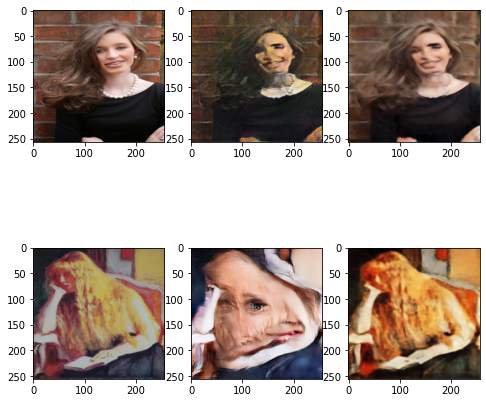

Epoch No. = 155
Loss_DA = 0.05631361825019849
Loss_DB = 0.040458506986615246
Loss_G = 3.2054751645326616
Epoch No. = 160
Loss_DA = 0.053645312481981816
Loss_DB = 0.03860302260844765
Loss_G = 3.1855375757217406


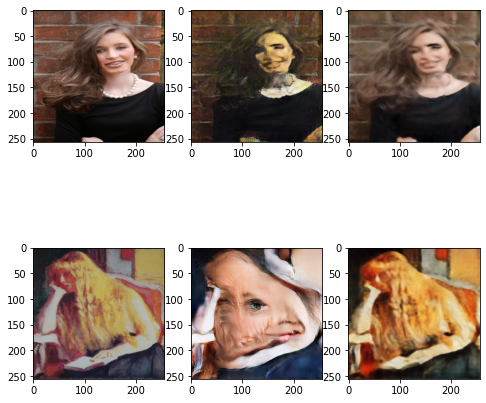

Epoch No. = 165
Loss_DA = 0.05403103921399452
Loss_DB = 0.03891422875333956
Loss_G = 3.1728274532556533
Epoch No. = 170
Loss_DA = 0.05472590138384112
Loss_DB = 0.03449335232164958
Loss_G = 3.1152936537265776


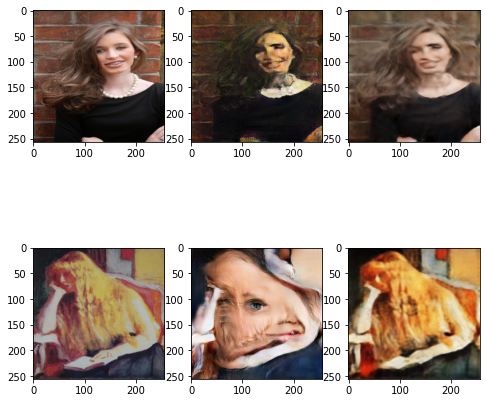

Epoch No. = 175
Loss_DA = 0.05075818192256156
Loss_DB = 0.030943995507892397
Loss_G = 3.112940728187561
Epoch No. = 180
Loss_DA = 0.04736626962746959
Loss_DB = 0.028312893346623243
Loss_G = 3.1053218368291855


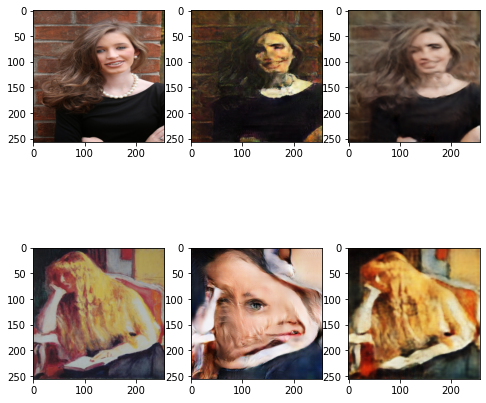

Epoch No. = 185
Loss_DA = 0.04542075085319811
Loss_DB = 0.023700945135919027
Loss_G = 3.084456325054169
Epoch No. = 190
Loss_DA = 0.04286768944738651
Loss_DB = 0.01881858046337584
Loss_G = 3.0891417851448058


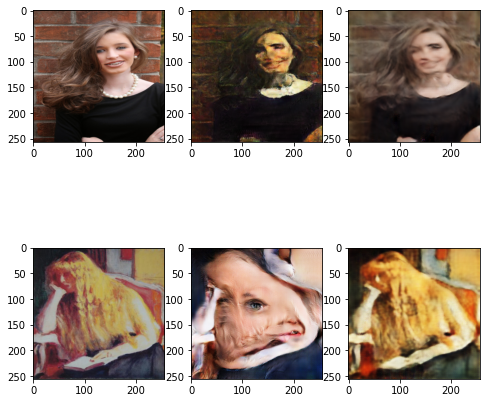

Epoch No. = 195
Loss_DA = 0.03741689422068885
Loss_DB = 0.012173116269616003
Loss_G = 3.124907430291176
Epoch No. = 200
Loss_DA = 0.028253988756921897
Loss_DB = 0.005445639663544625
Loss_G = 3.290028033256531


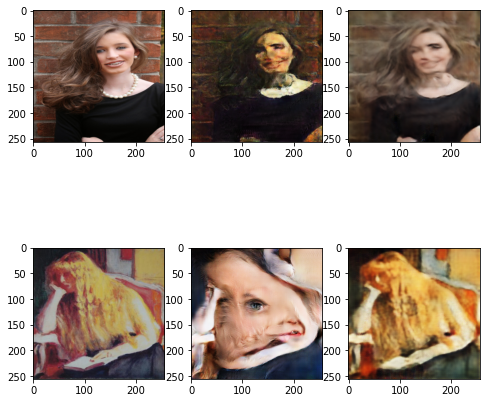

In [19]:
poolA = ImagePool()
poolB = ImagePool()
lossDA = []
lossDB = []
lossG = []
fake_logitsA = []
real_logitsA = []
fake_logitsB = []
real_logitsB = []
for epoch in range(num_epochs):
    epoch_lossDA = []
    epoch_lossDB = []
    epoch_lossG = []
    for i,images in enumerate(loader_train):
        realA = images[0].to(device)
        realB = images[1].to(device)
        
        batch_size = realA.size()[0]
        
        real_labelsA = torch.ones(batch_size,1).to(device)
        real_labelsB = torch.ones(batch_size,1).to(device)
        
        fake_labelsA = torch.zeros(batch_size,1).to(device)
        fake_labelsB = torch.zeros(batch_size,1).to(device)
        
        DA.zero_grad()
        DB.zero_grad()
        
        fakeB = GA(realA)
        fakeA = GB(realB)
        
       
        
        #For Discriminator
        fakeA1 = poolA.get_batch(fakeA)
        fakeB1 = poolB.get_batch(fakeB)
        
        
        #print(fakeA1)
        
        fakeA_logit = DB(fakeA1.detach())
        fakeB_logit = DA(fakeB1.detach())
        
        fake_logitsA.append(fakeA_logit)
        fake_logitsB.append(fakeB_logit)
        
        loss_fakeA = criterionGAN(fakeA_logit,fake_labelsA)
        loss_fakeB = criterionGAN(fakeB_logit,fake_labelsB)
        
        realA_logit = DB(realA)
        realB_logit = DA(realB)
        
        real_logitsA.append(realA_logit.cpu().item())
        real_logitsB.append(realB_logit.cpu().item())
        
        loss_realA = criterionGAN(realA_logit, real_labelsA)
        loss_realB = criterionGAN(realB_logit,real_labelsB)
        
        loss_DA = 0.5*(loss_fakeB + loss_realB)
        loss_DB = 0.5*(loss_fakeA + loss_realA)
        
        epoch_lossDA.append(loss_DA.cpu().item())
        epoch_lossDB.append(loss_DB.cpu().item())
        
        loss_DA.backward()
        loss_DB.backward()
        
        optimDA.step()
        optimDB.step()
        
        
        
        #FOR Generator
        GA.zero_grad()
        GB.zero_grad()
        
        fakeA_logit_gen = DB(fakeA)
        fakeB_logit_gen = DA(fakeB)
        
        gan_loss = criterionGAN(fakeA_logit_gen, real_labelsA) + criterionGAN(fakeB_logit_gen,real_labelsB) 
        
        cycleA = GB(fakeB)
        cycleB = GA(fakeA)
        
        cycle_loss = lambda_cycle*(criterionCycle(cycleA,realA) + criterionCycle(cycleB,realB))
        gen_loss = gan_loss + cycle_loss
        
        epoch_lossG.append(gen_loss.cpu().item())
        
        gen_loss.backward()
        
        optimG.step()
        
    lossDA.append(sum(epoch_lossDA)/len(epoch_lossDA))
    lossDB.append(sum(epoch_lossDB)/len(epoch_lossDB))
    lossG.append(sum(epoch_lossG)/len(epoch_lossG))
    
    schedulerG.step()
    schedulerDA.step()
    schedulerDB.step()
    
    if (epoch+1)%5==0 or epoch==0:
        print("Epoch No. = "+ str(epoch+141))
        print("Loss_DA = "+ str(lossDA[epoch]))
        print("Loss_DB = "+ str(lossDB[epoch]))
        print("Loss_G = "+ str(lossG[epoch]))
        
    if (epoch+1)%10==0:
        torch.save({
            'GA_state_dict': GA.state_dict(),
            'GB_state_dict': GB.state_dict(),
            'DA_state_dict': DA.state_dict(),
            'DB_state_dict': DB.state_dict(),
            'optG_state_dict': optimG.state_dict(),
            'optDA_state_dict': optimDA.state_dict(),
            'optDB_state_dict': optimDB.state_dict(),
            }, '/content/drive/Shareddrives/AML_Project/new_models/CycleGAN_epoch-{}.pth'.format(epoch+141))
        
        with torch.no_grad():
          GA.eval()
          GB.eval()
          test_fakeB = GA(testA)
          reconstructA = GB(test_fakeB)
          test_fakeA = GB(testB)
          reconstructB = GA(test_fakeA)
          GA.train()
          GB.train()
          show_images = [testA.cpu(),test_fakeB.cpu(),reconstructA.cpu(),testB.cpu(),test_fakeA.cpu(),reconstructB.cpu()]
          fig=plt.figure(figsize=(8, 8))
          columns = 3
          rows = 2
          for i in range(1, columns*rows+1):
            img = show_images[i-1][0].permute(1,2,0)
            fig.add_subplot(rows, columns, i)
            plt.imshow((img+1.)/2.)
          plt.show()